# Rheological Parameter Exploration
Using TidalPy's high-level functional programming, we will see how different rheological parameters affect tidal dissipation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf')

from TidalPy.constants import mass_solar, radius_solar, luminosity_solar, mass_earth, radius_earth, au, G
from TidalPy.tools.toolbox import quick_tidal_dissipation
from TidalPy.tools.conversions import days2rads
from TidalPy.utilities.numpy_helper.array_other import neg_array_for_log_plot
from TidalPy.utilities.graphics.cmaps import vik_map
from TidalPy.stellar import equilibrium_insolation_williams

plt.rcParams['figure.figsize'] = [9.5 * .75, 6 * .75]
plt.rcParams.update({'font.size': 14})
%matplotlib notebook

### Planetary Properties
We will use planetary properties approximately based on the exoplanet: TRAPPIST 1e

In [2]:
# TRAPPIST-1 (the star) Parameters [Stassun+2019, Gillon+2017]
star_lumonsity = 10**(-3.28) * luminosity_solar
star_radius = 0.1148270 * radius_solar
star_mass = 0.09077820 * mass_solar

# TRAPPIST-1e Parameters [Grimm+2018]
planet_radius = 0.910 * radius_earth
planet_mass = 0.772 * mass_earth
planet_semi_major_axis = 0.02928285 * au
planet_orbital_period = 6.099615
planet_orbital_frequency = days2rads(planet_orbital_period)
planet_eccentricity = 0.00510
planet_obliquity = 0.
planet_moi = (2. / 5.) * planet_mass * planet_radius**2
# We will assume that only 50% of the world's volume is participating in tidal dissipation
tidal_scale = 0.5
# Calculate other properties
planet_density = planet_mass / ((4. / 3.) * np.pi * planet_radius**3)
planet_gravity = G * planet_mass / (planet_radius**2)

# Calculate insolation heating for the system

## Viscosity Domain
Here we calculate tidal heating versus insolation temperature in over a domain of mantle viscosity

<IPython.core.display.Javascript object>


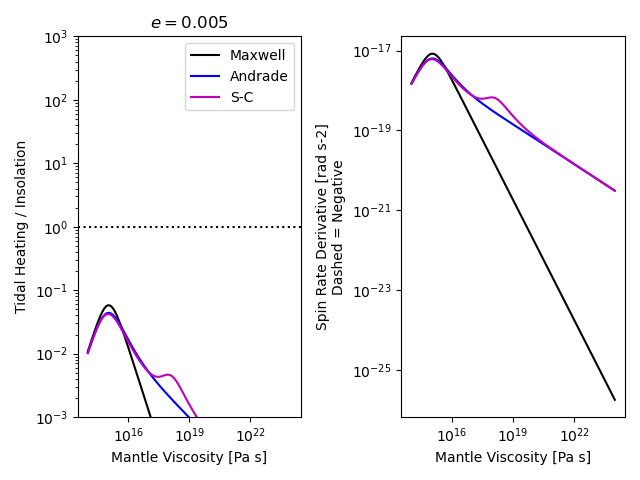

interactive(children=(FloatSlider(value=0.2, description='voigt_compliance_offset', max=1.0, min=0.01, step=0.…

In [3]:
# Setup domain
viscosity_domain = np.logspace(14., 24., 100)
shear_domain = 50.e9 * np.ones_like(viscosity_domain)

# Setup figure
fig_sync, axes_sync = plt.subplots(ncols=2, nrows=1)
fig_sync.tight_layout(pad=4.0)
ax_sync_heating = axes_sync[0]
ax_sync_torque = axes_sync[1]
ax_sync_heating.set(xlabel='Mantle Viscosity [Pa s]', ylabel='Tidal Heating / Insolation', yscale='log',
                    xscale='log', ylim=(1e-3, 1e3))
ax_sync_torque.set(xlabel='Mantle Viscosity [Pa s]', ylabel='Spin Rate Derivative [rad s-2]\nDashed = Negative',
                   yscale='log', xscale='log')

# Plot lines
ax_sync_heating.axhline(y=1e0, color='k', ls=':')
rheo_lines_heating = [ax_sync_heating.plot(viscosity_domain, viscosity_domain, 'k', label='Maxwell')[0],
                      ax_sync_heating.plot(viscosity_domain, viscosity_domain, 'b', label='Andrade')[0],
                      ax_sync_heating.plot(viscosity_domain, viscosity_domain, 'm', label='S-C')[0]]
rheo_lines_torque = [ax_sync_torque.plot(viscosity_domain, viscosity_domain, 'k', label='Maxwell')[0],
                     ax_sync_torque.plot(viscosity_domain, viscosity_domain, 'b', label='Andrade')[0],
                     ax_sync_torque.plot(viscosity_domain, viscosity_domain, 'm', label='Sundberg-Cooper')[0]]
rheo_lines_torque_neg = [ax_sync_torque.plot(viscosity_domain, viscosity_domain, '--k', label='Maxwell')[0],
                         ax_sync_torque.plot(viscosity_domain, viscosity_domain, '--b', label='Andrade')[0],
                         ax_sync_torque.plot(viscosity_domain, viscosity_domain, '--m', label='S-C')[0]]
plt.show()

def sync_rotation(voigt_compliance_offset=.2,
                  voigt_viscosity_offset=.02,
                  alpha=.333,
                  zeta_power=0.,
                  albedo=0.3,
                  eccentricity_pow=np.log10(planet_eccentricity),
                  obliquity_deg=0.,
                  force_spin_sync=True,
                  spin_orbit_ratio=1.,
                  eccentricity_truncation_lvl=2,
                  max_tidal_order_l=2):
    
    eccentricity = 10.**eccentricity_pow
    zeta = 10.**(zeta_power)
    obliquity = np.radians(obliquity_deg)
    dissipation_data = dict()
    rheology_data = {
        'maxwell': (rheo_lines_heating[0], rheo_lines_torque[0], rheo_lines_torque_neg[0],
                    tuple()),
        'andrade': (rheo_lines_heating[1], rheo_lines_torque[1], rheo_lines_torque_neg[1],
                    (alpha, zeta)),
        'sundberg': (rheo_lines_heating[2], rheo_lines_torque[2], rheo_lines_torque_neg[2],
                     (voigt_compliance_offset, voigt_viscosity_offset, alpha, zeta)),
    }
    
    if force_spin_sync:
        spin_period = None
    else:
        # The ratio is in the denominator since it is a frequency ratio.
        spin_period = planet_orbital_period / spin_orbit_ratio
        
    # Calculate insolation based on distance and eccentricity
    insolation = \
        equilibrium_insolation_williams(star_lumonsity, planet_semi_major_axis, albedo, planet_radius, eccentricity)
    
    for rheo_name, (heating_line, torque_line, torque_neg_line, rheo_input) in rheology_data.items():
        # Perform main tidal calculation
        dissipation_data[rheo_name] = \
            quick_tidal_dissipation(star_mass, planet_radius, planet_mass, planet_gravity, planet_density,
                                    viscosity_domain, shear_domain, rheology=rheo_name,
                                    complex_compliance_inputs=rheo_input, eccentricity=eccentricity, obliquity=obliquity,
                                    orbital_period=planet_orbital_period, spin_period=spin_period,
                                    max_tidal_order_l=max_tidal_order_l,
                                    eccentricity_truncation_lvl=eccentricity_truncation_lvl)
        
        spin_derivative = dissipation_data[rheo_name]['dUdO'] * (star_mass / planet_moi)
        heating_line.set_ydata(dissipation_data[rheo_name]['tidal_heating'] / insolation)
        spin_derivative_pos = np.copy(spin_derivative)
        spin_derivative_pos[spin_derivative_pos<=0.] = np.nan
        spin_derivative_neg = np.copy(spin_derivative)
        spin_derivative_neg[spin_derivative_neg>0.] = np.nan
    
        torque_line.set_ydata(np.abs(spin_derivative_pos))
        torque_neg_line.set_ydata(np.abs(spin_derivative_neg))
        
    
    ax_sync_heating.legend(loc='best')
    ax_sync_heating.relim()
    ax_sync_heating.autoscale_view()
    ax_sync_heating.set_title('$e = ' + f'{eccentricity:0.3f}' +'$')
    ax_sync_torque.relim()
    ax_sync_torque.autoscale_view()
    fig_sync.canvas.draw_idle()

run_interactive_sync = interact(
    sync_rotation,
    voigt_compliance_offset=(0.01, 1., 0.05),
    voigt_viscosity_offset=(0.01, 0.1, 0.01),
    alpha=(0.05, 0.5, 0.02),
    zeta_power=(-5, 5, 0.5),
    albedo=(0.1, 0.9, 0.05),
    eccentricity_pow=(-4, -0.09, .1),
    obliquity_deg=(0., 90., 1),
    force_spin_sync=True,
    spin_orbit_ratio=(.5, 8., .1),
    eccentricity_truncation_lvl=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    max_tidal_order_l=[2, 3]
)

## Resonance Trapping
Here we look at how material properties change how a planet can become trapped at a higher-order spin-orbit resonance

<IPython.core.display.Javascript object>


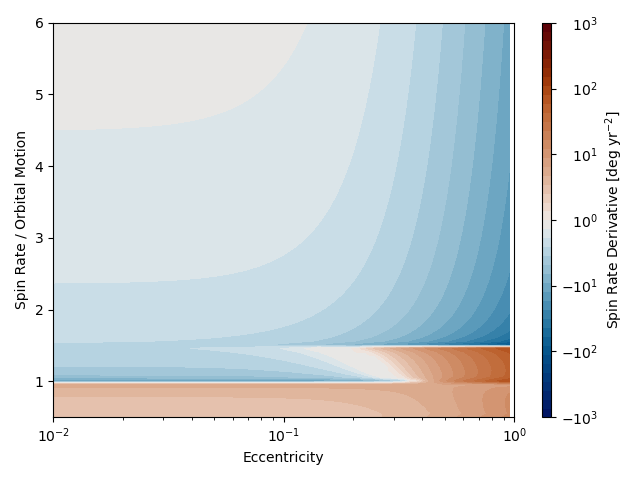

interactive(children=(Dropdown(description='cbar_scale_set', index=2, options=(0, 1, 2, 3, 4, 5), value=2), Fl…

In [6]:
# Setup scales
scale_info_list = [
((86400.)**2 * (360. / (2. * np.pi)), '[deg day$^{-2}$]'),
((2.628e+6)**2 * (360. / (2. * np.pi)), '[deg month$^{-2}$]'),
((3.154e7)**2 * (360. / (2. * np.pi)), '[deg yr$^{-2}$]'),
((3.154e7 * 10)**2 * (360. / (2. * np.pi)),'[deg dyr$^{-2}$]'),
((3.154e7 * 100)**2 * (360. / (2. * np.pi)), '[deg cyr$^{-2}$]'),
((3.154e7 * 1000)**2 * (360. / (2. * np.pi)), '[deg kyr$^{-2}$]')
]

cpoints = np.linspace(-3, 3, 45)
zticks = [-3, -2, -1, 0, 1, 2, 3]
zlabels = ['$-10^{3}$', '$-10^{2}$', '$-10^{1}$',
           '$\\;\\;\\;10^{0}$', '$\\;\\;\\;10^{1}$', '$\\;\\;\\;10^{2}$', '$\\;\\;\\;10^{3}$']

# Setup domain
x = eccentricity_domain = np.logspace(-2., 0., 100)
y = spin_ratio_domain = np.linspace(0.5, 6., 110)
eccen_mtx, spin_ratio_mtx = np.meshgrid(eccentricity_domain, spin_ratio_domain)
shape = eccen_mtx.shape
eccen_mtx = eccen_mtx.flatten()
spin_ratio_mtx = spin_ratio_mtx.flatten()
spin_frequency = spin_ratio_mtx * planet_orbital_frequency

# Setup figure
fig_trap = plt.figure()
gs = GridSpec(1, 2, figure=fig_trap, wspace=None, hspace=None, width_ratios=[.98, .02])
ax_trap = fig_trap.add_subplot(gs[0, 0])
ax_cb = fig_trap.add_subplot(gs[0, 1])
fig_sync.tight_layout()
ax_cb.set(ylabel='Spin Rate Derivative [rad s-2]')

plt.show()

def sync_rotation(cbar_scale_set=2,
                  voigt_compliance_offset=.2,
                  voigt_viscosity_offset=.02,
                  alpha=.333,
                  zeta_power=0.,
                  viscosity_power=22.,
                  shear_power=10.69897,
                  obliquity_deg=0.,
                  eccentricity_truncation_lvl=2,
                  max_tidal_order_l=2):
    
    viscosity = 10.**viscosity_power
    shear = 10.**shear_power
    zeta = 10.**zeta_power
    obliquity = np.radians(obliquity_deg)
    rheo_input = (voigt_compliance_offset, voigt_viscosity_offset, alpha, zeta)
    
    if max_tidal_order_l > 2 and eccentricity_truncation_lvl == 22:
        raise NotImplemented
    
    dissipation_data = \
        quick_tidal_dissipation(star_mass, planet_radius, planet_mass, planet_gravity, planet_density,
                                viscosity, shear, rheology='sundberg',
                                complex_compliance_inputs=rheo_input, eccentricity=eccen_mtx, obliquity=obliquity,
                                orbital_frequency=planet_orbital_frequency, spin_frequency=spin_frequency,
                                max_tidal_order_l=max_tidal_order_l,
                                eccentricity_truncation_lvl=eccentricity_truncation_lvl)
        
    spin_derivative = dissipation_data['dUdO'] * (star_mass / planet_moi)
            
    scale, unit_label = scale_info_list[cbar_scale_set]
    
    spin_derivative = spin_derivative * scale
    spin_derivative = spin_derivative.reshape(shape)
    dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(spin_derivative)
    
    # Make data Symmetric Log (for negative logscale plotting)
    logpos = np.log10(np.copy(dspin_dt_targ_pos))
    logpos[logpos < 0.] = 0.
    negative_index = ~np.isnan(dspin_dt_targ_neg)
    logneg = np.log10(dspin_dt_targ_neg[negative_index])
    logneg[logneg < 0.] = 0.
    dspin_dt_targ_combo = logpos
    dspin_dt_targ_combo[negative_index] = -logneg

    ax_trap.clear()
    cb_data = ax_trap.contourf(x, y, dspin_dt_targ_combo, cpoints, cmap=vik_map)
    
    ax_cb.clear()
    cb = plt.colorbar(cb_data, cax=ax_cb, ticks=zticks)
    
    ax_trap.set(xlabel='Eccentricity', ylabel='Spin Rate / Orbital Motion', yscale='linear',
                xscale='log')
    cb.set_label('Spin Rate Derivative ' + unit_label)
    cb.ax.set_yticklabels(zlabels)
    fig_trap.canvas.draw_idle()
    plt.tight_layout()

run_interactive_sync = interact(
    sync_rotation,
    cbar_scale_set = [0, 1, 2, 3, 4, 5],
    voigt_compliance_offset=(0.01, 1., 0.05),
    voigt_viscosity_offset=(0.01, 0.1, 0.01),
    alpha=(0.05, 0.5, 0.02),
    zeta_power=(-5, 5, 0.5),
    viscosity_power=(14., 28., 1),
    shear_power=(7., 11., .5),
    obliquity_deg=(0., 90., 1),
    eccentricity_truncation_lvl=[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
    max_tidal_order_l=[2, 3]
)